# Beijing Air Quality Forecasting Starter Notebook

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

In [2]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/content/drive/MyDrive/beijing_pm2.5_data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/beijing_pm2.5_data/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [4]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [5]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [6]:
"""Gives a general overview of the dataset including the nuber of samples, number of columns non null entries in each column. We can immediately see that there are  some null entries in the pm2.5 column"""
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30676 entries, 0 to 30675
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        30676 non-null  int64  
 1   DEWP      30676 non-null  float64
 2   TEMP      30676 non-null  float64
 3   PRES      30676 non-null  float64
 4   Iws       30676 non-null  float64
 5   Is        30676 non-null  float64
 6   Ir        30676 non-null  float64
 7   datetime  30676 non-null  object 
 8   cbwd_NW   30676 non-null  float64
 9   cbwd_SE   30676 non-null  float64
 10  cbwd_cv   30676 non-null  float64
 11  pm2.5     28755 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 2.8+ MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13148 entries, 0 to 13147
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        13148 non-null  int64  
 1   DEWP      13148 non-null  float64
 2   TEMP      13148 non-null  float64
 3   PRES      13148 non-null  float64
 4   Iws       13148 non-null  float64
 5   Is        13148 non-null  float64
 6   Ir        13148 non-null  float64
 7   datetime  13148 non-null  object 
 8   cbwd_NW   13148 non-null  float64
 9   cbwd_SE   13148 non-null  float64
 10  cbwd_cv   13148 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 1.1+ MB


In [8]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

(train['datetime'].max() - train['datetime'].min()).days



1278

In [ ]:
# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


<Axes: xlabel='datetime'>

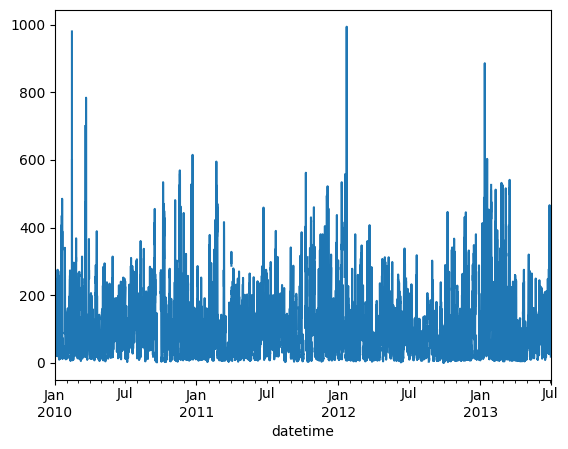

In [11]:
"""0-50 μg/m³: Good air quality
50-100 μg/m³: Moderate pollution
100+ μg/m³: Unhealthy levels



"""

train['pm2.5'].plot()

# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [17]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [8]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

In [9]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train = np.expand_dims(X_train, axis=1)

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [10]:
# define model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)

# Display the model architecture
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train the model
# You can adjust the number of epochs and batch size to improve performance.
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32
)

Epoch 1/100
907/907 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lambda: 69.2472 - loss: 5068.4688
Epoch 2/100
907/907 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 69.2634 - loss: 5079.6426
Epoch 3/100
907/907 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 69.9793 - loss: 5165.9883
Epoch 4/100
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 68.4694 - loss: 5007.1465
Epoch 5/100
907/907 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - lambda: 70.6989 - loss: 5338.9648
Epoch 6/100
907/907 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 69.2884 - loss: 5054.2236
Epoch 7/100
907/907 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 69.4315 - loss: 5111.6387
Epoch 8/100
907/907 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - lambda: 69.0764 - loss: 5063.5112
Epoch 9/100
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lambda: 69.3577 - loss: 5114.6226
Epoch 10/100
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 68.7507 - loss: 5034.6899
Epoch 11/100
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 68.3887 - loss: 4942.9849
Epoch 12/100
907/90

907/907 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


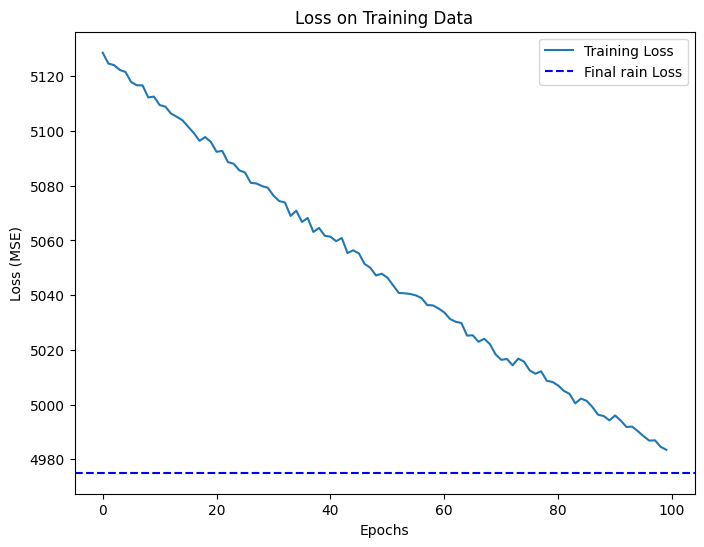

Final Training Loss (MSE): 4975.0774143314065


In [17]:
# Calculate training loss
train_predictions = model.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final rain Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [20]:
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/beijing_pm2.5_data/subm_fixed.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
